# HuggingFace 프로젝트

### 프로젝트 내용
- HuggingFace의 Transformers와 Datasets를 활용하여 네이버 영화 감성 분석을 시행하여 90% 이상의 accuracy를 얻어낸다.  


- KLUE를 활용한다.
    - https://huggingface.co/klue/bert-base  
    
- 데이터셋:
    - https://github.com/e9t/nsmc
- 버켓팅을 적용한다.

### 데이터셋 불러오기
- 1. txt 파일을 pandas의 dataFrame으로 불러온다.
- 2. Dataset.from_pandas()를 이용하여 허깅페이스 데이터셋으로 변환한다.

In [1]:
import tensorflow
import numpy
import transformers
import datasets
from datasets import load_dataset
import os

In [2]:
# NSMC 데이터셋 로드
dataset = load_dataset("nsmc")

# 데이터셋 정보 확인
print(dataset)
dataset['train'][:10]

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


{'id': ['9976970',
  '3819312',
  '10265843',
  '9045019',
  '6483659',
  '5403919',
  '7797314',
  '9443947',
  '7156791',
  '5912145'],
 'document': ['아 더빙.. 진짜 짜증나네요 목소리',
  '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
  '너무재밓었다그래서보는것을추천한다',
  '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
  '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
  '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
  '원작의 긴장감을 제대로 살려내지못했다.',
  '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
  '액션이 없는데도 재미 있는 몇안되는 영화',
  '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?'],
 'label': [0, 1, 0, 0, 1, 0, 0, 0, 1, 1]}

In [3]:
# id 라는 피처는 필요가 없으니까 지우자.

train_dataset = dataset['train'].remove_columns('id')
test_dataset = dataset['test'].remove_columns('id')
print(train_dataset)
print(test_dataset)


Dataset({
    features: ['document', 'label'],
    num_rows: 150000
})
Dataset({
    features: ['document', 'label'],
    num_rows: 50000
})


In [4]:
# 데이터 양이 많으면 학습 시간이 오래 걸린다.
# 모델 학습에 쓸 데이터 양을 좀 줄여보자.
# 훈련 세트: 20000개
# 검증 세트: 4000개
# 테스트 세트: 4000개

train_final = train_dataset.select(range(20000))
eval_final = train_dataset.select(range(20000, 20000 + 4000))
test_final = test_dataset.select(range(4000))

print("훈련 세트 크기:", len(train_final))
print("검증 세트 크기:", len(eval_final))
print("테스트 세트 크기:", len(test_final))

훈련 세트 크기: 20000
검증 세트 크기: 4000
테스트 세트 크기: 4000


### 모델과 토크나이저 불러오기
- AutoModelForSequenceClassification과 AutoTokenizer를 활용하여 klue/bert-base를 불러온다.
- AutoModel을 사용하기보다는 어떤 태스크를 할지 명확하게 지정하는 게 좋다.
- AutoModel로 하면 classification이라고 인식을 못하네.


In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

### 전처리 하기

In [6]:
def tokenize_function(data):
    return tokenizer(
        data['document'],
        truncation=True,
        # 토크나이저 단계에서 패딩을 하지 않는다.
        # 패딩은 데이터 콜레이터가 동적으로 하도록 한다.
        padding=False, 
        max_length=128,
        return_token_type_ids=False
    )

In [7]:
# Tokenize the dataset
train_final = train_final.map(tokenize_function, batched=True)
eval_final = eval_final.map(tokenize_function, batched=True)
test_final = test_final.map(tokenize_function, batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [8]:
# 전처리 결과 확인하기.
for element in train_final[:1].values():
    print(element)
print('\n')    
for element in eval_final[:1].values():
    print(element)
print('\n')    
for element in test_final[:1].values():
    print(element)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['아 더빙.. 진짜 짜증나네요 목소리']
[[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3]]
[0]


[[1, 1, 1]]
['4']
[[2, 24, 3]]
[0]


[[1, 1, 1, 1]]
['굳 ㅋ']
[[2, 618, 191, 3]]
[1]


In [9]:
train_final[:1]

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'document': ['아 더빙.. 진짜 짜증나네요 목소리'],
 'input_ids': [[2,
   1376,
   831,
   2604,
   18,
   18,
   4229,
   9801,
   2075,
   2203,
   2182,
   4243,
   3]],
 'label': [0]}

In [10]:
# 데이터 콜레이터
# 동적 패딩을 사용하기 위한 과정이라고 생각하자.

from transformers import DataCollatorWithPadding 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

### Trainer를 통한 학습 진행하기

In [11]:
import numpy as np
from transformers import Trainer, TrainingArguments


output_dir = os.getcwd()
print(output_dir)

training_args = TrainingArguments(
    output_dir,
    evaluation_strategy="epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    num_train_epochs = 3,
    weight_decay = 0.01,
    group_by_length=True
)

/aiffel/aiffel/HuggingFace_custom_project


In [12]:
from datasets import load_metric
metric = load_metric('glue', 'mrpc') # 이진 분류에 맞는 평가 지표를 선택한다.

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)


In [13]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_args,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_final,    # training dataset
    eval_dataset=eval_final,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 939


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.299676,0.872500,0.862829
2,0.307400,0.296178,0.879500,0.884079
3,0.307400,0.294611,0.890500,0.889894


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
Saving model checkpoint to /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500
Configuration saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/HuggingFace_custom_project/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
The following columns in the evaluation set  don't

TrainOutput(global_step=939, training_loss=0.25080446643443405, metrics={'train_runtime': 333.8165, 'train_samples_per_second': 179.739, 'train_steps_per_second': 2.813, 'total_flos': 732435400358400.0, 'train_loss': 0.25080446643443405, 'epoch': 3.0})

In [14]:
trainer.save_model(output_dir + "/manual_saved_model")

Saving model checkpoint to /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model
Configuration saved in /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model/config.json
Model weights saved in /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/HuggingFace_custom_project/manual_saved_model/special_tokens_map.json


In [15]:
trainer.evaluate(test_final)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64


{'eval_loss': 0.29879769682884216,
 'eval_accuracy': 0.8845,
 'eval_f1': 0.8843264897346019,
 'eval_runtime': 18.4113,
 'eval_samples_per_second': 217.258,
 'eval_steps_per_second': 3.422,
 'epoch': 3.0}

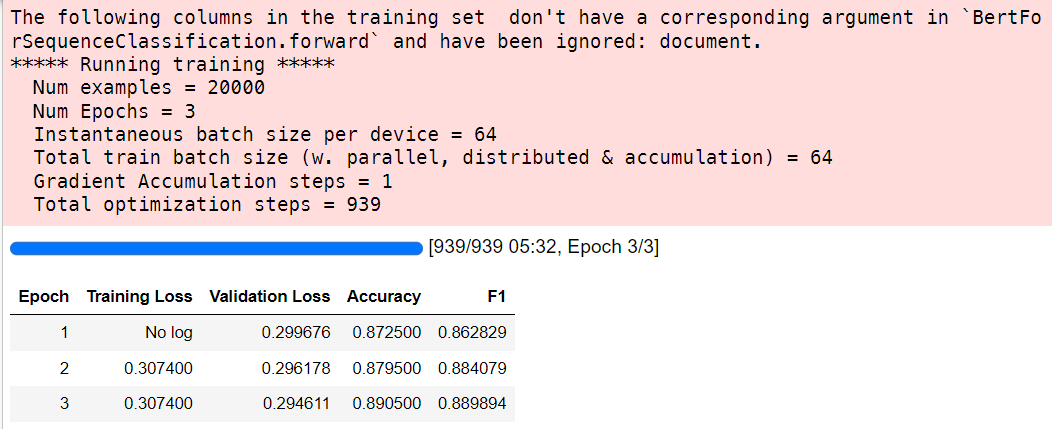
- 동적 패딩을 사용하지 않은 훈련 시간: 20분
- 동적 패딩을 사용한 훈련 시간: 5분 30초